In [1]:
# Refer to path of package
import sys
sys.path.append('/Users/watcharapongwongrattanasirikul/Documents/Git/Jupyter/my_env/lib/python3.8/site-packages')

In [2]:
# Import Lib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import re
from random import choices, randint, randrange, uniform

In [3]:
from ml_helper import MlHelper
from eda_helper import EdaHelper
from sampling_helper import SamplingHelper
from impute_helper import ImputeHelper
from impute_helper import imputation_strategy
from ml_helper import model_type
from ml_helper import resampler_type
from ml_helper import scaler_type

In [4]:
file_path = '/Users/watcharapongwongrattanasirikul/Documents/Git/predictive-maintenance/train_timeseries.csv'

df = pd.read_csv(file_path)
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
# Rename of columns
df = df.rename(columns={
    'Air temperature [K]':'AirTemp',
    'Process temperature [K]':'ProcessTemp',
    'Rotational speed [rpm]':'RotationalSpeed',
    'Torque [Nm]':'Torque',
    'Tool wear [min]': 'ToolWear',
    'Machine failure':'MF'
})
df.head()

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Feature Engineering

In [8]:
def log_feature(val):
    result = np.log(val)
    
    if result not in [np.inf, -np.inf, np.NaN]:
        return result
    else:
        return 0

In [9]:
def devide_feature(val):
    if val[1] == 0:
        return 0
    else:
        return val[0]/val[1]

In [10]:
# Add log feature
df['AirTempLog'] = (df['AirTemp']).transform(log_feature)
df['ProcessTempLog'] = (df['ProcessTemp']).transform(log_feature)
df['RotationalSpeedLog'] = (df['RotationalSpeed']).transform(log_feature)
df['TorqueLog'] = (df['Torque']).transform(log_feature)
df['ToolWearLog'] = (df['ToolWear']).transform(log_feature)

In [11]:
# Add devided feature

df['AirTempProcessTempDevided'] = (df[['AirTemp', 'ProcessTemp']]).apply(devide_feature, axis=1)
df['TorqueRotationalSpeedDevided'] = (df[['Torque', 'RotationalSpeed']]).apply(devide_feature, axis=1)

In [12]:
# Add square feature

df['AirTempSq'] = (df['AirTemp']) * (df['AirTemp'])
df['ProcessTempSq'] = (df['ProcessTemp']) * (df['ProcessTemp'])
df['RotationalSpeedSq'] = (df['RotationalSpeed']) * (df['RotationalSpeed'])
df['TorqueSq'] = (df['Torque']) * (df['Torque'])
df['ToolWearSq'] = (df['ToolWear']) * (df['ToolWear'])

In [13]:
# This function use to encode data point to be class label
# a = data less than or equal percentile 25
# b = data less than or equal percentile 50
# c = data less than or equal percentile 75
# d = data greater than percentile 75

def encode_feature(df):
    
    mean = np.mean(df)
    std = np.std(df)
    
    encoder_list = []
    
    for data_point in df:
        
        if data_point <= (mean - (3*std)):
            encoder_list.append(1)
            continue
        
        if data_point <= (mean - (2*std)):
            encoder_list.append(2)
            continue
            
        if data_point <= (mean - (1*std)):
            encoder_list.append(3)
            continue
            
        if data_point <= mean:
            encoder_list.append(4)
            continue
            
        if data_point <= (mean + (1*std)):
            encoder_list.append(5)
            continue
            
        if data_point <= (mean + (2*std)):
            encoder_list.append(6)
            continue       
                        
        encoder_list.append(7)

    return encoder_list

In [14]:
df['Airtemp_Class'] = encode_feature(df['AirTemp'])
df['ProcessTemp_Class'] = encode_feature(df['ProcessTemp'])
df['Rotational_Class'] = encode_feature(df['RotationalSpeed'])
df['Torque_Class'] = encode_feature(df['Torque'])
df['ToolWear_Class'] = encode_feature(df['ToolWear'])

In [15]:
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,...,AirTempSq,ProcessTempSq,RotationalSpeedSq,TorqueSq,ToolWearSq,Airtemp_Class,ProcessTemp_Class,Rotational_Class,Torque_Class,ToolWear_Class
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,...,88863.61,95233.96,2405601,1831.84,0,3,3,5,5,3
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,...,88923.24,95295.69,1982464,2143.69,9,3,4,4,5,3


In [16]:
def plot_class_distribution(df, label):
    c = ['Grey', 'Red']
    df.groupby('MF').size().plot(kind="bar", color=c)
    plt.title('Class Distribution', fontsize=18)
    plt.yticks(np.arange(0, 12000, 2000))
    # plt.grid()

    for index, value in enumerate(df.groupby(label).size()):
        c_label = ''
        if index == 0:
            c_label = 'Black'
        else:
            c_label = 'Red'
        plt.text(index - 0.1, value + 1000, str(value), color=c_label, fontsize=14)

    sns.despine()

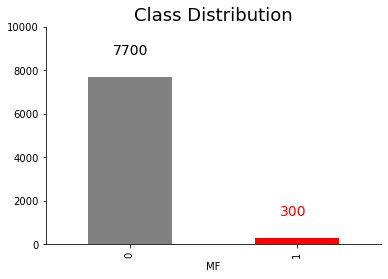

In [15]:
plot_class_distribution(df, 'MF')

# Genetic Algorithms to find the prediction pattern

## encoder function

In [17]:
# This function use to encode data point to be class label
# a = data less than or equal percentile 25
# b = data less than or equal percentile 50
# c = data less than or equal percentile 75
# d = data greater than percentile 75

def encode_feature(df):
    
    mean = np.mean(df)
    std = np.std(df)
    
    encoder_list = []
    
    for data_point in df:
        
        if data_point <= (mean - (3*std)):
            encoder_list.append('a')
            continue
        
        if data_point <= (mean - (2*std)):
            encoder_list.append('b')
            continue
            
        if data_point <= (mean - (1*std)):
            encoder_list.append('c')
            continue
            
        if data_point <= mean:
            encoder_list.append('d')
            continue
            
        if data_point <= (mean + (1*std)):
            encoder_list.append('e')
            continue
            
        if data_point <= (mean + (2*std)):
            encoder_list.append('f')
            continue       
                        
        encoder_list.append('g')

    return encoder_list

In [19]:
df_torque = df['Torque']

test_encoder = encode_feature(df_torque)
test_encoder[:10]

['e', 'e', 'e', 'd', 'e', 'e', 'e', 'e', 'c', 'c']

### Generate the random genome by specific length

In [20]:
def generate_genome(length:int,num_group=1):
    
    
    previous_gene = ''
    or_logic = False
    count_or = 0
    genome_group = []
    
    for j in range(num_group):
        
        genome = []
        for i in range(length):

            # First character should not be symbol
            if i == 0:
                next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                continue

            # Last character should not be symbol
            if i == (length-1):
                next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                continue

            # If previous character is symbol then next character should not be symbol
            if previous_gene[0] == '.*' or previous_gene[0] == '|':
                next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                genome = genome + next_gene

                if previous_gene[0] == '|':
                    or_logic = True
                    count_or = 2

                previous_gene = next_gene
                continue

            if count_or > 0:
                next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                count_or = count_or - 1
                continue

            next_gene = choices(['a','b','c','d','e','f','g','.*','|'], k=1)            
            genome = genome + next_gene
            previous_gene = next_gene
        genome_group.append(genome) 
    
    return genome_group

In [21]:
test_genome = generate_genome(5,2)
test_genome

[['e', 'b', 'a', 'e', 'b'], ['b', 'a', 'a', 'g', 'c']]

### Generate the population

In [22]:
def generate_population(size, genome_lenght, num_group=1):
    return [generate_genome(genome_lenght, num_group) for _ in range(size)]

In [23]:
test_population = generate_population(3, 5, 2)
test_population

[[['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['c', 'b', 'f', '|', 'd'], ['a', '|', 'b', 'f', 'c']],
 [['f', 'f', 'g', 'd', 'd'], ['c', '.*', 'b', 'f', 'a']]]

### Get expression

In [24]:
def get_expression(data, num_group):
    
    
    or_flag = False
    expression_group = []
    
    for j in range(num_group):
        reg_result = ""
        
        for idx, i in enumerate(data[j]):

            if i == '|' and reg_result == "":
                raise Exception(f"The symbol '|' can't be the first parameter: {data}")

            if i == '|' and (idx + 1) == len(data[j]):
                raise Exception(f"The symbol '|' can't be the last parameter: {data}")

            if i in ('a', 'b', 'c', 'd','e','f','g','.*') and or_flag == False:
                reg_result = reg_result + i
                buf = i
                continue

            if i in ('a', 'b', 'c', 'd','e','f','g','.*') and or_flag == True:
                reg_result = reg_result + f"{i}]"
                or_flag = False
                continue

            if or_flag == True and (i == '|' or i == '.*'):
                reg_result = reg_result + 'd'
                continue

            if i == '|':
                reg_result = reg_result[0:(len(reg_result)- len(buf))]
                reg_result = reg_result + f"[{buf}|"
                or_flag = True
                continue
                
        expression_group.append('.*'+reg_result+".*")
 
    return expression_group

In [26]:
test_expression = get_expression(test_genome, 2)

print(test_genome)
print(test_expression)

[['e', 'b', 'a', 'e', 'b'], ['b', 'a', 'a', 'g', 'c']]
['.*ebaeb.*', '.*baagc.*']


### Calculate the fitness score

In [27]:
def fitness(genome, encoder_result, df_state, window_size=20, is_print_counting = False, num_group=2):
    
    # Initial setting for window
    start = 0
    end = window_size
    number_round = int(len(encoder_result)/window_size)-1
    
    has_match_pattern = False
    
    fitness_score = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    # Parameter for counting
    count_predict_true = 0
    count_predict_false = 0
    count_not_match = 0
    
    # Get reg function from genome
    reg_expressions = get_expression(genome, num_group)
    
    predict_list = []
    
    # Iterate over the data by specific period
    for i in range(0, number_round):
        
        # Start by pattern doesn't matched
        predict_fail = False 
        
        # Get current pattern of feature
        current_pattern = ''.join(encoder_result[start:end])
        
        
        for reg_expression in reg_expressions:
            if predict_fail == True:
                continue
            
            matched = re.search(reg_expression, current_pattern)
            
            if matched is not None:
                predict_fail = True
                
                if has_match_pattern == False:
                    has_match_pattern = True
            else:
                predict_fail = False
        

        
        # Find the next period will have the fail case or not
        fail_next_period = list(df_state[end:end+window_size])
        is_fail_next_period = sum(fail_next_period)>0
    
        # Calculate Fitness Score
        if  predict_fail == True and is_fail_next_period == True:
            TP += 1
            
        if predict_fail == True and is_fail_next_period == False:
            FP += 1
            
        if predict_fail == False and is_fail_next_period == False:
            TN += 1
            
        if predict_fail == False and is_fail_next_period == True:
            FN += 1
            
            

        start += window_size
        end += window_size
        
    if (TP+FN) == 0:
        recall = 0
    else:
        recall = TP/(TP + FN)
    
    if (TP+FP) == 0:
        precision = 0
    else:
        precision = TP/(TP+FP)
    
    if (precision+recall) == 0:
        fitness_score = 0
    else:
        fitness_score = 2 * ((precision * recall)/(precision+recall))
    
    if is_print_counting == True:
        print(f'Count True: {count_predict_true}, False: {count_predict_false}, Not match: {count_not_match}')
    
    return(fitness_score)

In [28]:
df_PWF = df['PWF']
df_torque = df['Torque']
encode_torque = encode_feature(df_torque)

In [29]:
test_genome = generate_genome(length=5, num_group=2)
test_genome
score = fitness(test_genome, encode_torque, df_PWF, 40)
print(score)

0.3975155279503106


### Selection Pair

In [30]:
def selection_pair(population, weights, number=10):
    return choices(
        population=population,
        weights= weights,
        k=number
    )

In [31]:
test_population

[[['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['c', 'b', 'f', '|', 'd'], ['a', '|', 'b', 'f', 'c']],
 [['f', 'f', 'g', 'd', 'd'], ['c', '.*', 'b', 'f', 'a']]]

In [32]:
weights = [1, 0, 0]
selected_genome = selection_pair(test_population, weights)
selected_genome

[[['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']],
 [['d', 'c', 'd', 'a', 'g'], ['c', '.*', 'f', '|', 'f']]]

### Cross Over

In [33]:
def single_point_cross_over(genome1, genome2, num_group=2):
    
    genome_result1 = []
    genome_result2 = []

    
    for i in range(num_group):
        if len(genome1[i]) != len(genome2[i]):
            print(genome1[i])
            print(genome2[i])
            raise ValueError("Genomes 1 and 2 must be of same length")

        length = len(genome1[i])

        if length < 2:
            offspring1 = genome1[i]
            offspring2 = genome2[i]

        if length >= 2:    
            position = randint(1, length-1)
            offspring1 = genome1[i][0:position] + genome2[i][position:]
            offspring2 = genome2[i][0:position] + genome1[i][position:]
        
        genome_result1.append(offspring1)
        genome_result2.append(offspring2)
        
    return genome_result1, genome_result2

In [36]:
test_genome1 = [[1, 2, 3, 4 ,5], [6, 7, 8, 9, 10], [11,12,13,14,15]]
test_genome2 = [[15,14,13,12,11],[10, 9 , 8, 7, 6], [5, 4, 3, 2, 1]]

print(single_point_cross_over(test_genome1, test_genome2, num_group=3))

([[1, 2, 3, 12, 11], [6, 7, 8, 7, 6], [11, 12, 13, 14, 1]], [[15, 14, 13, 4, 5], [10, 9, 8, 9, 10], [5, 4, 3, 2, 15]])


### Mutation

In [37]:
def mutation(genome, number=1, num_group=2):
    for i in range(num_group):
        for _ in range(number):
            index = randrange(len(genome[i]))
            genome[i][index] = choices(['a','b','c','d','e','f','g'], k=1)[0]

    return genome

In [38]:
test_genome3 = [[1, 2, 3, 4 ,5], [6, 7, 8, 9, 10]]
new = mutation(test_genome3)
new

[[1, 2, 3, 'a', 5], ['e', 7, 8, 9, 10]]

### Evolution

In [41]:
def run_evolution(encoded_feature, df_state, generation_limit=100, population_size=10, genome_length=10, num_group=2,):
    
    # Parameter setting
    pop_crossover_threshold = 0.80
    pop_mutation_threshold = 0.02
    
    # --------------------------------------- 1. Generate Population --------------------------------------- #
    population = generate_population(size=population_size, genome_lenght=genome_length, num_group=num_group)
    
    for i in range(generation_limit):
        
        # 1. Calculate fitness score for all population
        fitness_scores = [fitness(genome, encoded_feature, df_state=df_state, window_size=20, is_print_counting=False) for genome in population]

        max_score = max(fitness_scores)

        print(f'round {i} has max score {max_score}.')  #The whole score list {fitness_scores}')

        # 2. Evaluation
        if max_score >= 0.8:
            population_and_score = list(zip(score, population))
            sorted_population_and_score = population_and_score.sort(reverse=True)
            top_population = sorted_population_and_score[0]
            print(f"The best population is {top_population[1]} with score {top_population[0]}")
            break

        # 3. Select new population
        adjust_score = [i for i in fitness_scores]
        weight_selection = [i/sum(adjust_score) for i in adjust_score] # Weight for random new population
        new_population = selection_pair(population, weight_selection, 10)

        # 4. Crossover
        offspring = []
        
        all_idx = list(range(len(new_population)))
        
        for idx, genome in enumerate(new_population):
            
            # Check index doesn't use yet
            if idx not in all_idx:
                continue
                
            # Remove the index of genome
            all_idx.remove(idx)
            
            # Get random index of other genome
            random_idx = choices(all_idx)[0]
            other_genome = new_population[random_idx]
            
            # Remove the index of other genome
            all_idx.remove(random_idx)
            
            # Check pop to cross over
            pop_crossover = uniform(0, 1)

            if pop_crossover <= pop_crossover_threshold:
#                 print(f'cross {idx} and {random_idx}')
                offspring1, offspring2 = single_point_cross_over(genome, other_genome, num_group=num_group)
            else:
#                 print(f'not cross {idx} and {random_idx}')
                offspring1, offspring2 = genome, other_genome
                    
            offspring.append(offspring1)
            offspring.append(offspring2)

        new_population = offspring.copy()

    
        # 5. Mutation
        for idx, genome in enumerate(new_population):
            pop_mutation = uniform(0, 1)
            if pop_mutation <= pop_mutation_threshold: 
                new_population[idx] = mutation(genome)
        
        population = new_population
        
        # 6. Exist loop when exceed the generation_limit
        if i == generation_limit - 1:
            fitness_scores = [fitness(genome, encoded_feature, df_PWF) for genome in population]
            population_and_score = list(zip(fitness_scores, population))
            population_and_score.sort(reverse=True)
            top_population = population_and_score[0]
            print(f"Last round the best population is {top_population[1]} with score {top_population[0]}")
            
    return(fitness_scores)
        

In [42]:
df_MF = df['MF']

In [43]:
run_evolution(
    encoded_feature=encode_torque,
    df_state=df_MF,
    generation_limit=10000,
    population_size=10,
    genome_length=5,
    num_group=2,)

round 0 has max score 0.3357664233576642.
round 1 has max score 0.5936395759717314.
round 2 has max score 0.5950704225352113.
round 3 has max score 0.5950704225352113.
round 4 has max score 0.5950704225352113.
round 5 has max score 0.5950704225352113.
round 6 has max score 0.5961199294532628.
round 7 has max score 0.5950704225352113.
round 8 has max score 0.5950704225352113.
round 9 has max score 0.4355300859598854.
round 10 has max score 0.5256410256410257.
round 11 has max score 0.4355300859598854.
round 12 has max score 0.4355300859598854.
round 13 has max score 0.4355300859598854.
round 14 has max score 0.4355300859598854.
round 15 has max score 0.4355300859598854.
round 16 has max score 0.4355300859598854.
round 17 has max score 0.4355300859598854.
round 18 has max score 0.4355300859598854.
round 19 has max score 0.4355300859598854.
round 20 has max score 0.4355300859598854.
round 21 has max score 0.4355300859598854.
round 22 has max score 0.4437869822485207.
round 23 has max scor

KeyboardInterrupt: 

In [340]:
['f', 'c', '|', 'e', 'd'], ['f', 'c', 'a', 'g', 'd']
['g', '|', 'c', 'a', 'b'], ['g', 'f', '|', 'd', 'd']

(['c', 'b', 'g', 'b', 'g'], ['e', 'g', '|', 'b', 'f'])

In [ ]:
['f', 'c', '|', 'a', 'b'], ['f', 'f', '|', 'd', 'd']
['g', '|', 'c', 'e', 'd'], ['g', 'c', 'a', 'g', 'd']

In [ ]:
df_feature = df_scale['Tor-Rot']
feature_encoded = encode_feature(df_feature) 

In [ ]:
df_PWF = df['PWF']

In [ ]:
population = generate_population(10, 5)

score = run_evolution(population, encode_torque, df_PWF, 20000)

In [ ]:
a = ['A', 'B', 'C']
b = [3, 2, 1]

result = zip(b, a)
c =list(result)

In [ ]:
c

In [ ]:
c.sort(reverse=False)
c

In [ ]:
c[0][1]

In [ ]:
encode_torque

In [ ]:
for i in scores:
    print(type(i))

In [ ]:
weight = [i/sum(scores) for i in scores]
weight

In [ ]:
a1

In [ ]:
a2 = mutation(a1)

In [ ]:
a2

In [ ]:
a = generate_genome(10)
b = generate_genome(10)

In [ ]:
a1, b1 = single_point_cross_over(a, b)

In [ ]:
print(a)
print(b)
print(a1)
print(b1)

In [ ]:
fitness(test_genome, encode_torque, 'a')

In [ ]:
population_test = generate_population(10, 10)

In [ ]:
p = selection_pair(population_test, fitness)

In [263]:
randint(1, 10)

2

In [ ]:
a = generate_genome(10)
a

In [ ]:
get_expression(a)

In [ ]:
# Test rolling windows

test_list = [1,2,3,4,5,7,8,9,10]

windows = pd.DataFrame(test_list).rolling(2)

for idx, i in enumerate(windows):
    print(list(i[0]))

In [ ]:
a = [1,2,3,4]

In [ ]:
weight = [i/sum(a) for i in a]

In [ ]:
weight